### Auto encoder (AE)
**Author**: @leopauly | cnlp@leeds.ac.uk <br>
**Description**: An implementation of autoencoder. A combination of MNIST and USPS charactor recognition datasets is used for training and testing the model.


In [1]:
from numpy.random import seed
seed(9)
from tensorflow import set_random_seed
set_random_seed(2)
import os
os.environ['PYTHONHASHSEED'] = '0'

CUDA_VISIBLE_DEVICES=""

In [2]:
import os
os.environ["KERAS_BACKEND"] = "theano"
import keras; import keras.backend
if keras.backend.backend() != 'theano':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('th')
    print("Backend ok")

Using Theano backend.


Backend ok


In [3]:
## Imports
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D, Input, Lambda
from keras.utils import np_utils
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers
import keras.backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Custom scripts
from myhelperfunctions import *

In [4]:
## Variable values
b_size=24
nb_classes=10
n_z=32

#### Defining model

In [5]:
#Encoder network
inputs = Input(shape=(256,))
layer1 = Dense(128, activation='relu')(inputs)
layer2 = Dense(64, activation='relu')(layer1)
layer3 = Dense(n_z, activation='linear',  activity_regularizer=regularizers.l1(0.0))(layer2) #sigmoid
encoder=Model(inputs,layer3)

In [6]:
#Decoder network for autoencoder
inputs_d = Input(shape=(n_z,))
layer1_d = Dense(64, activation='relu')(inputs_d)
layer2_d = Dense(128, activation='relu')(layer1_d)
layer3_d = Dense(256, activation='sigmoid')(layer2_d)
decoder=Model(inputs_d,layer3_d)

#Net Model
inputs_m = Input(shape=(256,))
z=encoder(inputs_m)
output_m=decoder(z)
net_model=Model(inputs_m,output_m)

#### Loading MNIST & USPS dataset

Display numpy-images : MNIST 16x16 after normalisation to 0-1
(16, 16)
[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.00392157  0.12156863  0.59607846  0.44313726  0.07843138
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.03137255  0.1882353   0.61960787  0.94509804  0.90196079  0.47843137
   0.01568628  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00392157
   0.15294118  0.47450981  0.81568629  0.95294118  0.74901962  0.8509804
   0.61960787  0.02352941  0.     

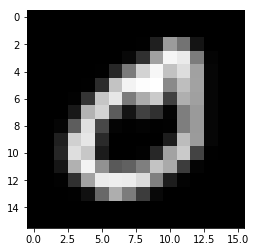

Display numpy-images : USPS 16x16 after normalisation to 0-1
(16, 16)
[[ 0.0000365   0.003178    0.0498455   0.1836895   0.27842751  0.272782
   0.262564    0.284412    0.25273049  0.208176    0.21567351  0.299867
   0.4222725   0.45699951  0.31546149  0.0886945 ]
 [ 0.000079    0.0068555   0.1089155   0.42177501  0.697604    0.74693501
   0.73790002  0.76167899  0.72753447  0.67713702  0.681669    0.74962598
   0.82360899  0.80387199  0.55534202  0.1601465 ]
 [ 0.000054    0.0047745   0.0812955   0.3908405   0.8158865   0.95978302
   0.96468198  0.96276599  0.92502999  0.87904352  0.86345249  0.85652751
   0.83722299  0.783871    0.55056202  0.164014  ]
 [ 0.0000365   0.003278    0.0598465   0.34029251  0.80466747  0.98330301
   0.98204052  0.922566    0.808608    0.67959899  0.60448402  0.53092653
   0.44464701  0.37166101  0.221719    0.059555  ]
 [ 0.0000655   0.005763    0.095676    0.4284105   0.84339702  0.98624599
   0.96179301  0.84984249  0.68738598  0.47737601  0.29939151  0

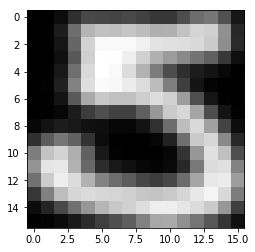

(7000, 256)
(930, 256)
(7000,)
(930,)


In [7]:
mnist_x_new_train, mnist_x_new_test, mnist_y_new_train, mnist_y_new_test,usps_x_new_train, usps_x_new_test, usps_y_new_train, usps_y_new_test=datasets(.1,.1)
mnist_train_y = np_utils.to_categorical(mnist_y_new_train, nb_classes)
usps_train_y = np_utils.to_categorical(usps_y_new_train-1, nb_classes)
mnist_test_y= np_utils.to_categorical(mnist_y_new_test, nb_classes)
usps_test_y = np_utils.to_categorical((usps_y_new_test-1), nb_classes)

#### Compiling and training model

In [8]:
def lossfunction(y_true,y_pred):
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    return recon

In [9]:
# Compile model
net_model.compile(loss=lossfunction, optimizer='adam', metrics=['accuracy'])
net_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256)               0         
_________________________________________________________________
model_1 (Model)              (None, 32)                43232     
_________________________________________________________________
model_2 (Model)              (None, 256)               43456     
Total params: 86,688
Trainable params: 86,688
Non-trainable params: 0
_________________________________________________________________


In [10]:
print (np.shape(mnist_x_new_train),np.shape(usps_x_new_train))
print (np.shape(mnist_x_new_test),np.shape(usps_x_new_test))
adda_train=np.concatenate((mnist_x_new_train,usps_x_new_train),axis=0)  #  [0:8368]: for class balanced training
adda_test=np.concatenate((mnist_x_new_test,usps_x_new_test),axis=0)
print (np.shape(adda_train),np.shape(adda_test))

(63000, 256) (8368, 256)
(7000, 256) (930, 256)
(71368, 256) (7930, 256)


In [11]:
net_model.fit(adda_train, adda_train, epochs=80, batch_size=b_size,validation_data=(adda_test,adda_test),shuffle=True)

Train on 71368 samples, validate on 7930 samples
Epoch 1/80
71368/71368 [==============================] - 13s - loss: 50.3160 - acc: 0.1967 - val_loss: 44.8210 - val_acc: 0.2676
Epoch 2/80
71368/71368 [==============================] - 15s - loss: 44.1613 - acc: 0.2957 - val_loss: 43.3422 - val_acc: 0.3319
Epoch 3/80
71368/71368 [==============================] - 15s - loss: 43.2285 - acc: 0.3318 - val_loss: 42.7516 - val_acc: 0.3523
Epoch 4/80
71368/71368 [==============================] - 15s - loss: 42.7575 - acc: 0.3519 - val_loss: 42.4996 - val_acc: 0.3523
Epoch 5/80
71368/71368 [==============================] - 15s - loss: 42.4710 - acc: 0.3626 - val_loss: 42.2343 - val_acc: 0.3728
Epoch 6/80
71368/71368 [==============================] - 15s - loss: 42.2735 - acc: 0.3729 - val_loss: 42.0437 - val_acc: 0.4025
Epoch 7/80
71368/71368 [==============================] - 15s - loss: 42.1283 - acc: 0.3768 - val_loss: 42.0061 - val_acc: 0.3699
Epoch 8/80
71368/71368 [=================

71368/71368 [==============================] - 29s - loss: 41.3535 - acc: 0.4262 - val_loss: 41.2707 - val_acc: 0.4291
Epoch 64/80
71368/71368 [==============================] - 29s - loss: 41.3550 - acc: 0.4292 - val_loss: 41.2898 - val_acc: 0.4329
Epoch 65/80
71368/71368 [==============================] - 29s - loss: 41.3501 - acc: 0.4274 - val_loss: 41.2582 - val_acc: 0.4338
Epoch 66/80
71368/71368 [==============================] - 29s - loss: 41.3489 - acc: 0.4295 - val_loss: 41.2528 - val_acc: 0.4276
Epoch 67/80
71368/71368 [==============================] - 29s - loss: 41.3487 - acc: 0.4287 - val_loss: 41.2550 - val_acc: 0.4358
Epoch 68/80
71368/71368 [==============================] - 29s - loss: 41.3459 - acc: 0.4277 - val_loss: 41.2508 - val_acc: 0.4409
Epoch 69/80
71368/71368 [==============================] - 29s - loss: 41.3429 - acc: 0.4289 - val_loss: 41.2734 - val_acc: 0.4401
Epoch 70/80
71368/71368 [==============================] - 29s - loss: 41.3394 - acc: 0.4269 - 

#### Saving model

In [12]:
# storing model to a json file and weights in HDF5 format
model_json = encoder.to_json()
# saving model
with open("adv_exp_1_ae_linear_no_sparse_encoder.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5 and saving it
encoder.save_weights("adv_exp_1_ae_linear_no_sparse_encoder.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
# storing model to a json file and weights in HDF5 format
model_json = decoder.to_json()
# saving model
with open("adv_exp_1_ae_linear_no_sparse_decoder.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5 and saving it
decoder.save_weights("adv_exp_1_ae_linear_no_sparse_decoder.h5")
print("Saved model to disk")

Saved model to disk


#### Visualising feature space

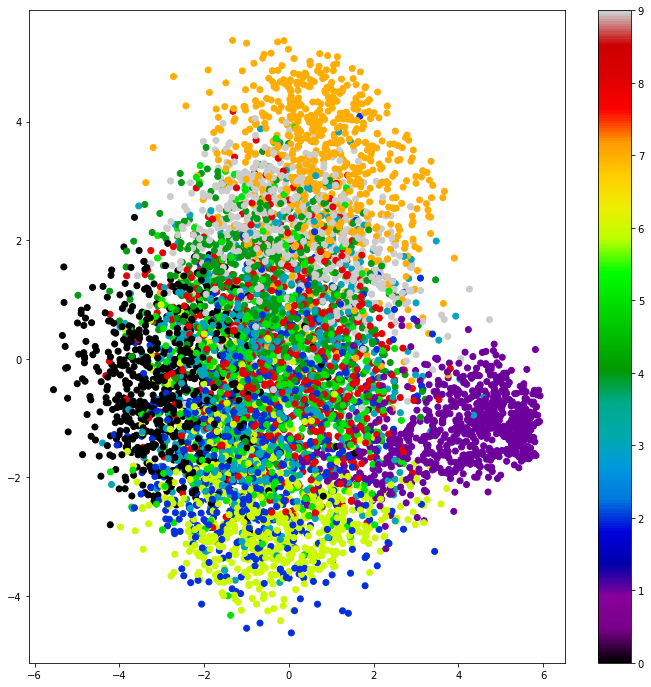

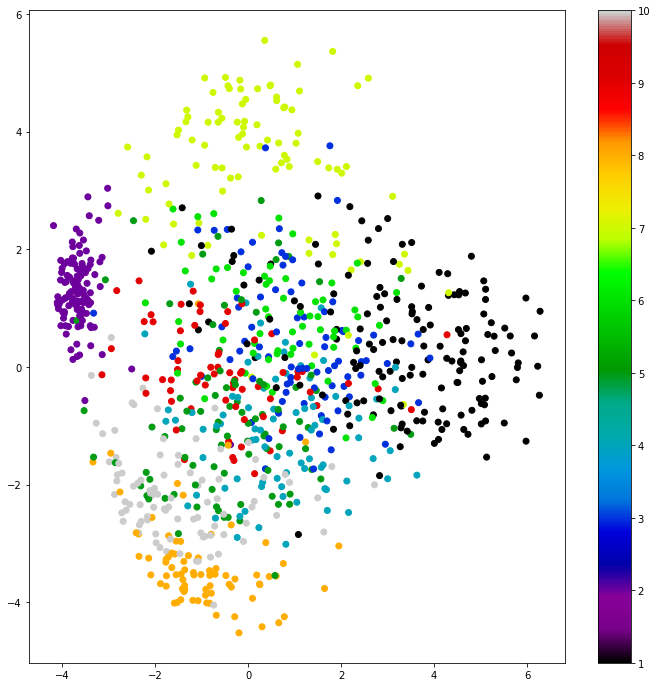

In [14]:
# 2D visualisation of features from images MNIST_test set in latent space 
latent_values_mnist = encoder.predict(mnist_x_new_test, batch_size=b_size)
latent_values_usps = encoder.predict(usps_x_new_test, batch_size=b_size)

vis_pca = PCA(n_components=2, random_state=0)
vis_data=vis_pca.fit_transform(latent_values_mnist)
plt.figure(figsize=(12, 12))
plt.scatter(vis_data[:, 0], vis_data[:, 1], c=mnist_y_new_test,cmap=plt.cm.nipy_spectral)
plt.colorbar()
plt.show()

# 2D visualisation of features from images USPS_test set in latent space 
vis_pca = PCA(n_components=2, random_state=0)
vis_data=vis_pca.fit_transform(latent_values_usps)
plt.figure(figsize=(12, 12))
plt.scatter(vis_data[:, 0], vis_data[:, 1], c=usps_y_new_test,cmap=plt.cm.nipy_spectral)
plt.colorbar()
plt.show()

In [15]:
a = np.asarray(latent_values_usps).reshape(-1)
print(np.shape(latent_values_usps))
print(np.shape(a))
print(min(a))

(930, 32)
(29760,)
-6.82179


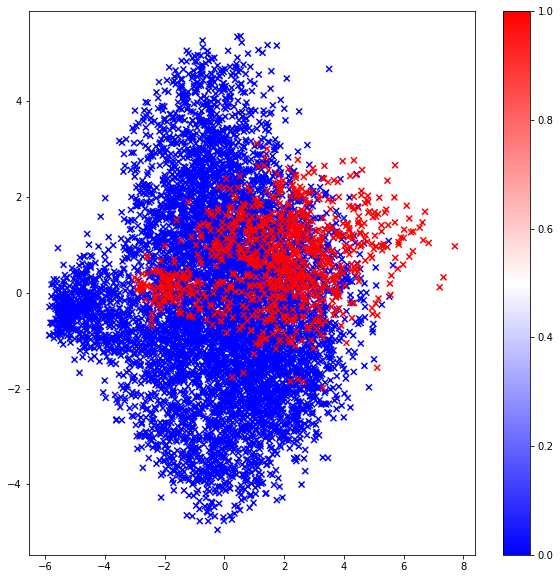

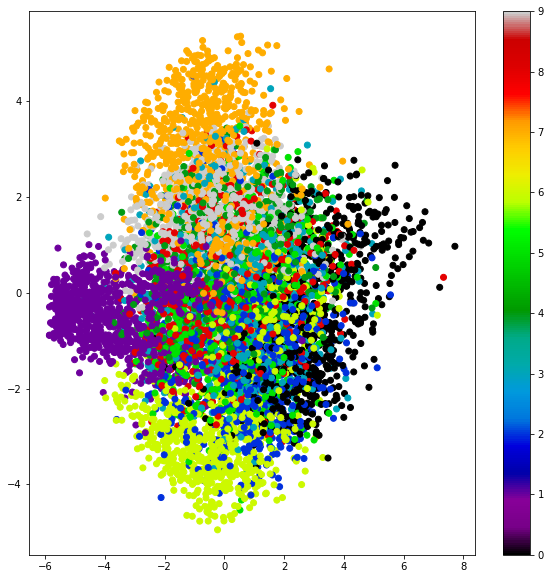

In [16]:
# 2D visualisation of features from images MNIST_test & USPS_test set in latent space 
# Red is USPS_test set & MNIST_test set
latent_values=np.concatenate((latent_values_mnist,latent_values_usps),axis=0)
labels_digits=np.concatenate((mnist_y_new_test,usps_y_new_test-1),axis=0)
labels_0=np.zeros(mnist_x_new_test.shape[0])
labels_1=np.ones(usps_x_new_test.shape[0])
labels=np.concatenate((labels_0,labels_1),axis=0)

vis_pca = PCA(n_components=2, random_state=0)
feature_vis=vis_pca.fit_transform(latent_values)

plt.figure(figsize=(10, 10))
plt.scatter(feature_vis[:, 0], feature_vis[:, 1], c=labels, marker='x', cmap=plt.cm.bwr, alpha=100)
plt.colorbar()
plt.show()

# 2D visualisation of features from images MNIST_test & USPS_test set in latent space 
plt.figure(figsize=(10, 10))
plt.scatter(feature_vis[:, 0], feature_vis[:, 1], c=labels_digits, marker='o', cmap=plt.cm.nipy_spectral, alpha=100)
plt.colorbar()
plt.show()

#### Testing reconstruction ability of model

In [17]:
def reconstructor():
    examples_to_show = 10
    encode_decode_ = net_model.predict(usps_x_new_test[0:24])
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(usps_x_new_test[i], (16, 16)))
        a[1][i].imshow(np.reshape(encode_decode_[i], (16, 16)))
    f.show()
    plt.draw()
    plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


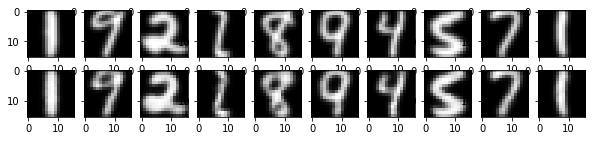

In [18]:
reconstructor()